In [1]:
import os, sys
project_path = '/content/gdrive/MyDrive/master/2.5D_sketches_estimator'
sys.path.append(project_path)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd {project_path}

/content/gdrive/MyDrive/master/2.5D_sketches_estimator


In [3]:
# import DL modules
import tensorflow as tf
import keras as keras
from keras.models import Sequential, Model
from keras import layers
from keras import optimizers
from keras.utils.vis_utils import plot_model
import tensorflow.keras.backend as K

# import service modules
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import json

In [4]:
#@title Setup
RUN_MODE = 'test'
OUTPUT_PATH = project_path+'/intermediate/sketch_estimator_depth/'
RANDOM_SEED = 10
SAMPLE_RATE = 1 #@param
N_EPOCH = 50 #@param {type: "integer"}
BATCH_SIZE = 64 #@param {type: "integer"}
VERBOSE = 1 #@param {type: "boolean"}
LOSS_FUNCTION = 'RMSE'
# LOSS_FUNCTION = 'MeanAbsoluteError'
VALIDATION_SPLIT = 0.2 #@param
TEST_SPLIT = 0.1 #@param
INPUT_SHAPE = (BATCH_SIZE, 256, 256, 3) #@param
HEIGHT = INPUT_SHAPE[1]
WIDTH = INPUT_SHAPE[2]
LR = 0.0002
OPTIMIZER = tf.optimizers.Adam(
  learning_rate=LR,
  amsgrad=False
)

# Load Data

In [5]:
# reference: https://keras.io/examples/vision/depth_estimation/
class DataLoader(tf.keras.utils.Sequence):
  def __init__(self, data, batch_size=64, dim=(256, 256), n_channels=3, shuffle=False):
    """
    Initialization
    """
    self.data = data
    self.x_file = self.data[0]
    self.y_file = self.data[1]
    self.indices = list(range(self.x_file.len()))
    self.dim = dim
    self.n_channels = n_channels
    self.batch_size = batch_size
    self.shuffle = shuffle
    self.on_epoch_end()

  def __len__(self):
    return int(np.ceil(len(self.indices) / self.batch_size))

  def __getitem__(self, index):
    # modify batch size of last batch
    if (index + 1) * self.batch_size > len(self.indices):
      self.batch_size = len(self.indices) - index * self.batch_size
    # Generate one batch of data
    # Generate indices of the batch
    index = self.indices[index * self.batch_size : (index + 1) * self.batch_size]
    # Find list of IDs
    batch = [self.indices[k] for k in index]
    x, y = self.load_batch(batch)
    return x, y


  def on_epoch_end(self):
    """
    Updates indexes after each epoch
    """
    self.index = np.arange(len(self.indices))
    if self.shuffle == True:
      np.random.shuffle(self.index)

  def load_batch(self, batch):
    """
    Load one batch of data.
    """ 
    x = self.x_file[batch[0]:batch[-1]+1]
    y = self.y_file[batch[0]:batch[-1]+1]
    return x, y

In [6]:
import h5py

In [7]:
hdf5_path = '/content/gdrive/MyDrive/master/Data/data_shuffled.hdf5'
train_dataset_file = (h5py.File(hdf5_path)['train_raw_image'], h5py.File(hdf5_path)['train_depth'])
test_dataset_file = (h5py.File(hdf5_path)['test_raw_image'], h5py.File(hdf5_path)['test_depth'])
validation_dataset_file = (h5py.File(hdf5_path)['validation_raw_image'], h5py.File(hdf5_path)['validation_depth'])

In [8]:
test = next(iter(DataLoader(data=test_dataset_file, batch_size=BATCH_SIZE, dim=INPUT_SHAPE[1:3], n_channels=INPUT_SHAPE[3], shuffle=True)))

In [9]:
print(test[0].shape)

(64, 256, 256, 3)


In [10]:
train_loader = DataLoader(data=train_dataset_file, batch_size=BATCH_SIZE, dim=INPUT_SHAPE[1:3], n_channels=INPUT_SHAPE[3], shuffle=True)
validation_loader = DataLoader(data=validation_dataset_file, batch_size=BATCH_SIZE, dim=INPUT_SHAPE[1:3], n_channels=INPUT_SHAPE[3], shuffle=True)
test_loader = DataLoader(data=test_dataset_file, batch_size=BATCH_SIZE, dim=INPUT_SHAPE[1:3], n_channels=INPUT_SHAPE[3], shuffle=True)

In [11]:
print(len(train_loader.index))
print(len(validation_loader.index))
print(len(test_loader.index))

34384
4298
4298


In [12]:
print(train_loader.__len__())

538


# Define Model

In [13]:
class EncodeBlock(layers.Layer):
  def __init__(self, filters, kernel_size, strides):
    super().__init__()
    self.conv1 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu1 = layers.LeakyReLU(alpha=0.2)
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu2 = layers.LeakyReLU(alpha=0.2)
    self.bn2 = layers.BatchNormalization()

    self.pool = layers.MaxPool2D(pool_size=(2, 2))
  def call(self, inputs):
    r2 = self.conv1(inputs)
    r2 = self.bn1(r2)
    r2 = self.relu1(r2)

    r2 = self.conv2(r2)
    r2 = self.bn2(r2)
    r2 = self.relu2(r2)

    r1 = self.pool(r2)
    return r1, r2

class DecodeBlock(layers.Layer):
  def __init__(self, filters, kernel_size, strides):
    super().__init__()
    self.us = layers.UpSampling2D(size=(2, 2))

    self.concat = layers.Concatenate()

    self.conv1 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu1 = layers.LeakyReLU(alpha=0.2)
    self.bn1 = layers.BatchNormalization()

    self.conv2 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu2 = layers.LeakyReLU(alpha=0.2)
    self.bn2 = layers.BatchNormalization()
  def call(self, inputs, passed_inputs):
    r = self.us(inputs)
    r = self.concat([r, passed_inputs])

    r = self.conv1(r)
    r = self.bn1(r)
    r = self.relu1(r)

    r = self.conv2(r)
    r = self.bn2(r)
    r = self.relu2(r)

    return r

class BottleNeckBlock(layers.Layer):
  def __init__(self, filters, kernel_size, strides):
    super().__init__()
    # self.drop = layers.Dropout(rate=0.5)
    self.conv1 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu1 = layers.LeakyReLU(alpha=0.2)

    self.conv2 = layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same', kernel_initializer = 'he_normal')
    self.relu2 = layers.LeakyReLU(alpha=0.2)
  def call(self, inputs):
    # r = self.drop(inputs)
    r = self.conv1(inputs)
    r = self.relu1(r)

    r = self.conv2(r)
    r = self.relu2(r)
    return r

In [14]:
class SketchEstimator(keras.Model):
  def __init__(self, kernel_size_encoder, strides_encoder, 
            kernel_size_bottle_neck, strides_bottle_neck,
            kernel_size_decoder, strides_decoder
            ):
    super().__init__()
    layers_filters = [16, 32, 64, 128, 256]
    # layers_filters = [32, 64, 128, 256, 256]
    self.encoder = [
      EncodeBlock(filters=layers_filters[0], kernel_size=kernel_size_encoder, strides=strides_encoder),
      EncodeBlock(filters=layers_filters[1], kernel_size=kernel_size_encoder, strides=strides_encoder),
      EncodeBlock(filters=layers_filters[2], kernel_size=kernel_size_encoder, strides=strides_encoder),
      EncodeBlock(filters=layers_filters[3], kernel_size=kernel_size_encoder, strides=strides_encoder),
    ]
    self.bottle_neck = BottleNeckBlock(layers_filters[4], kernel_size_bottle_neck, strides_bottle_neck)
    self.decoder = [
      DecodeBlock(filters=layers_filters[3], kernel_size=kernel_size_decoder, strides=strides_decoder),
      DecodeBlock(filters=layers_filters[2], kernel_size=kernel_size_decoder, strides=strides_decoder),
      DecodeBlock(filters=layers_filters[1], kernel_size=kernel_size_decoder, strides=strides_decoder),
      DecodeBlock(filters=layers_filters[0], kernel_size=kernel_size_decoder, strides=strides_decoder),
    ]
    self.out = layers.Conv2D(filters=3, kernel_size=3, strides=1, padding='same')
    # self.softmax = layers.Softmax()
  def call(self, inputs):
    e01, e02 = self.encoder[0](inputs)
    e11, e12 = self.encoder[1](e01)
    e21, e22 = self.encoder[2](e11)
    e31, e32 = self.encoder[3](e21)

    b = self.bottle_neck(e31)
    
    d = self.decoder[0](b, e32)
    d = self.decoder[1](d, e22)
    d = self.decoder[2](d, e12)
    d = self.decoder[3](d, e02)

    r = self.out(d)
    # r = self.softmax(r)
    r = tf.math.sigmoid(r)
    return r

In [15]:
model = SketchEstimator(3, 1, 
            3, 1,
            3, 1)
model.build(input_shape=(None, 256, 256, 3))
model.call(layers.Input((256, 256, 3)))
model.summary()

Model: "sketch_estimator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encode_block (EncodeBlock)  ((None, 128, 128, 16),    2896      
                              (None, 256, 256, 16))              
                                                                 
 encode_block_1 (EncodeBlock  ((None, 64, 64, 32),     14144     
 )                            (None, 128, 128, 32))              
                                                                 
 encode_block_2 (EncodeBlock  ((None, 32, 32, 64),     55936     
 )                            (None, 64, 64, 64))                
                                                                 
 encode_block_3 (EncodeBlock  ((None, 16, 16, 128),    222464    
 )                            (None, 32, 32, 128))               
                                                                 
 bottle_neck_block (BottleNe  (None, 16, 16, 256) 

## Losses

In [16]:
def rmse(y_true, y_pred):
  """
  Root Mean Squared Error
  Args:
      y_true ([np.array]): test samples
      y_pred ([np.array]): predicted samples
  Returns:
      [float]: root mean squared error
  """
  return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(y_true, y_pred))))
  # return K.sqrt(K.mean(K.square(y_pred - y_true), axis=-1))

In [17]:
# customized loss
def ssim_loss(target, pred):
  # Structural similarity (SSIM) index
  loss = tf.reduce_mean(
    1 - tf.image.ssim(
      target, pred, max_val=1.0, filter_size=3, k1=0.01 ** 2, k2=0.03 ** 2
    )
  )
  return loss

In [18]:
def L1_loss(target, pred):
  return tf.reduce_mean(tf.abs(target-pred))

In [19]:
def edge_loss(target, pred):
  dy_true, dx_true = tf.image.image_gradients(target)
  dy_pred, dx_pred = tf.image.image_gradients(pred)
  weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
  weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

  # Depth smoothness
  smoothness_x = dx_pred * weights_x
  smoothness_y = dy_pred * weights_y

  depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
      abs(smoothness_y)
  )
  return depth_smoothness_loss

In [20]:
def composite_loss(target, pred):
  ssim_loss_weight = 0.85
  l1_loss_weight = 0.1
  edge_loss_weight = 0.9

  # Edges
  dy_true, dx_true = tf.image.image_gradients(target)
  dy_pred, dx_pred = tf.image.image_gradients(pred)
  weights_x = tf.exp(tf.reduce_mean(tf.abs(dx_true)))
  weights_y = tf.exp(tf.reduce_mean(tf.abs(dy_true)))

  # Depth smoothness
  smoothness_x = dx_pred * weights_x
  smoothness_y = dy_pred * weights_y

  depth_smoothness_loss = tf.reduce_mean(abs(smoothness_x)) + tf.reduce_mean(
    abs(smoothness_y)
  )

  # Structural similarity (SSIM) index
  ssim_loss = tf.reduce_mean(
    1 - tf.image.ssim(
      target, pred, max_val=WIDTH, filter_size=3, k1=0.01 ** 2, k2=0.03 ** 2
    )
  )
  # Point-wise depth
  l1_loss = tf.reduce_mean(tf.abs(target - pred))

  loss = (
    (ssim_loss_weight * ssim_loss)
    + (l1_loss_weight * l1_loss)
    + (edge_loss_weight * depth_smoothness_loss)
  )

  return loss

In [21]:
# encoder-decoder
if LOSS_FUNCTION == 'SSIM':
  model.compile(loss=ssim_loss, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])
elif LOSS_FUNCTION == 'L1':
  model.compile(loss=L1_loss, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])
elif LOSS_FUNCTION == 'EDGE':
  model.compile(loss=edge_loss, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])
elif LOSS_FUNCTION == 'COMPOSITE':
  model.compile(loss=composite_loss, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])
elif LOSS_FUNCTION == 'RMSE':
  model.compile(loss=rmse, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])
else:
  model.compile(loss=LOSS_FUNCTION, optimizer=OPTIMIZER, metrics=['RootMeanSquaredError'])


# Train Model

In [22]:
# checkpoints
# additional checkpoint load code and temp directory definition
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

checkpoint_path = project_path+"/intermediate/unet/weights{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# definition of checkpoint parameters file
checkpoint = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=False, save_freq='epoch')

In [23]:
if RUN_MODE == 'train':
  # train
  history = model.fit(train_loader, batch_size=BATCH_SIZE, epochs=N_EPOCH, verbose=VERBOSE, validation_data=validation_loader, callbacks=[checkpoint])

In [24]:
if RUN_MODE == 'train':
  # save model
  model.save(OUTPUT_PATH+'model')
  with open(OUTPUT_PATH+'history.json', 'w+') as f:
    json.dump(dict(history.history), f)
  f.close()

# Demonstrate Results

In [25]:
if RUN_MODE == 'test':
  from keras.utils.generic_utils import get_custom_objects
  get_custom_objects().update({"rmse": rmse})
  model = load_model(OUTPUT_PATH+'model')

In [26]:
# print test score
test_score = model.evaluate(test_loader, verbose=1)
print("\nTest score/loss:", test_score[0])
print('Test accuracy:', test_score[1])

# Save records
with open(OUTPUT_PATH+'scores.json', 'w+') as f:
  json.dump(test_score, f)
f.close()


 1/68 [..............................] - ETA: 8:37 - loss: 0.0866 - root_mean_squared_error: 0.0866

KeyboardInterrupt: ignored

In [ ]:
import tensorflow.image as image_metric

# evaluation metrics
sample = next(iter(test_loader))
print(sample[0][0].shape)

preds = model.predict(sample[0])

metric_list = []
for i in range(BATCH_SIZE):
  pred = preds[i]
  true = tf.cast(sample[1][i], np.float32)
  ssim = image_metric.ssim(pred, true, max_val=1.0, filter_size=11)
  metric_list.append(ssim)
print(sum(metric_list)/len(metric_list))

for i in range(BATCH_SIZE):
  pred = preds[i]
  true = tf.cast(sample[1][i], np.float32)
  psnr = image_metric.psnr(pred, true, max_val=1.0)
  metric_list.append(psnr)
print(sum(metric_list)/len(metric_list))

In [ ]:
# if RUN_MODE == 'train':
# list all data in history
with open(OUTPUT_PATH+'history.json', 'r') as f:
  history = json.load(f)
f.close()
# summarize history for accuracy
plt.figure(figsize=(6,4))
plt.plot(history['root_mean_squared_error'])
plt.plot(history['val_root_mean_squared_error'])
plt.title('Loss History of the Depth Estimator')
plt.ylabel('Root Mean Squared Error')
plt.xlabel('Epoch')
plt.xticks(np.arange(0, N_EPOCH+2, 3.0))
plt.yticks(np.arange(0.0, 0.25, 0.02))
plt.xlim(0.0, N_EPOCH+2)
plt.ylim(0.0, 0.25)
plt.grid(True, lw=1, alpha=0.5, ls='--', c='gray')
plt.legend(['Training Dataset', 'Validation Dataset'], loc='upper right')
plt.savefig(OUTPUT_PATH+'loss_hist.png')
plt.show()

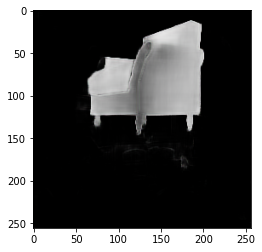

In [27]:
from google.colab.patches import cv2_imshow
test_result = model.predict(test[0])
plt.imshow(test_result[2])

In [ ]:
plt.imshow(test[0][2].astype(np.float))

In [ ]:
plt.imshow(test[1][2].astype(np.float))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `np.float` is a deprecated alias for 

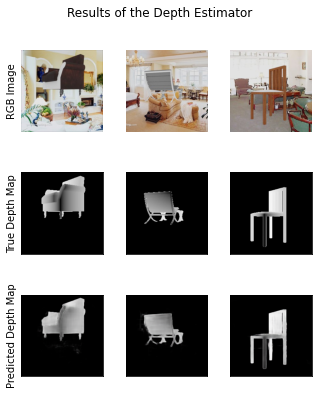

In [29]:
fig, axs = plt.subplots(3, 3)
plt.subplots_adjust(wspace=-0.5, hspace=0.5)
fig.set_figheight(6)
fig.set_figwidth(7.5)
fig.suptitle('Results of the Depth Estimator')

for ax in axs:
  for a in ax:
    plt.setp(a.get_xticklabels(), visible=False)
    plt.setp(a.get_yticklabels(), visible=False)
    a.tick_params(axis='both', which='both', length=0)

# plt.setp(axs[0, 0], ylabel='RGB Image')
# plt.setp(axs[1, 0], ylabel='Ground-truth Depth Map')
# plt.setp(axs[2, 0], ylabel='Estimated Depth Map')
# # plt.setp(axs[0, 0].get_yticklabels(), Fontsize=1)

axs[0, 0].set_ylabel('RGB Image', fontsize=10)
axs[1, 0].set_ylabel('True Depth Map', fontsize=10)
axs[2, 0].set_ylabel('Predicted Depth Map', fontsize=10)

axs[0, 0].imshow(test[0][2].astype(np.float))
axs[1, 0].imshow(test[1][2].astype(np.float))
axs[2, 0].imshow(test_result[2])
axs[0, 0].spines['right'].set_visible(False)
axs[0, 0].spines['left'].set_visible(False)
axs[0, 0].spines['top'].set_visible(False)
axs[0, 0].spines['bottom'].set_visible(False)

axs[0, 1].imshow(test[0][5].astype(np.float))
axs[1, 1].imshow(test[1][5].astype(np.float))
axs[2, 1].imshow(test_result[5])
axs[0, 1].spines['right'].set_visible(False)
axs[0, 1].spines['left'].set_visible(False)
axs[0, 1].spines['top'].set_visible(False)
axs[0, 1].spines['bottom'].set_visible(False)

axs[0, 2].imshow(test[0][3].astype(np.float))
axs[1, 2].imshow(test[1][3].astype(np.float))
axs[2, 2].imshow(test_result[3])
axs[0, 2].spines['right'].set_visible(False)
axs[0, 2].spines['left'].set_visible(False)
axs[0, 2].spines['top'].set_visible(False)
axs[0, 2].spines['bottom'].set_visible(False)


# print(type(axs[0, 0].tick_params(top='off', bottom='off', left='off', right='off', labelleft='off', labelbottom='on')))